# Robust Training with Jacobinet and Adversarial Attacks

This tutorial demonstrates the use of Jacobinet for robust training in neural networks. 
Jacobinet allows the backward pass of a neural network to be represented as a neural network with shared weights. 

**Goals:**
- Understand adversarial attacks (FGSM, PGD) and their impact on model robustness.
- Use Jacobinet to implement robust training by regularizing against adversarial examples.
- Evaluate robustness with AutoAttack for both baseline and robust training.

We will:
1. Train a baseline model and evaluate its adversarial robustness.
2. Train a robust model with adversarial regularization using Jacobinet.
3. Compare adversarial success rates for both models.


## Load and Preprocess Data

We will use the MNIST dataset for this tutorial. The dataset is normalized to the [0, 1] range and reshaped for compatibility with the convolutional model.


In [ ]:
import keras
import numpy as np
import matplotlib.pyplot as plt

# Load the MNIST data and split it into training and testing sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale the images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Reshape images to have an additional channel dimension (1, 28, 28)
x_train = np.expand_dims(x_train, 1)
x_test = np.expand_dims(x_test, 1)

# Convert class labels to one-hot encoded vectors
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)


## Define and Train the Baseline Model

We will build a simple Convolutional Neural Network (CNN) using Keras to serve as the baseline model. 
This model will be trained on MNIST and evaluated for accuracy on clean data.


In [ ]:
from keras import layers, Sequential

# Define the model architecture
model = Sequential(
    [
        layers.Input(shape=(1, 28, 28)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Flatten(),
        layers.Dense(10)
    ]
)
model.summary()

train_model = Sequential(model.layers + [layers.Activation('softmax')])
train_model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                    optimizer="adam",
                    metrics=["accuracy"])

train_model.fit(x_train, y_train, batch_size=128, epochs=2, validation_split=0.1)


In [ ]:
## Evaluate Robustness of Baseline Model

We use AutoAttack, a strong adversarial attack framework, to test the baseline model's robustness. 
AutoAttack generates adversarial examples by varying the attack radius (`epsilon`), and we measure the model's accuracy on these examples.


In [ ]:
import torchattacks
import torch

# Test robustness at different epsilon values
n = 100
random_index = np.random.permutation(len(x_test))[:n]
adv_acc = []
eps_values = [np.round(eps_i, 2) for eps_i in np.linspace(0.01, 0.2, 10)]

for eps in eps_values:
    print(eps)
    auto_attack = torchattacks.attacks.autoattack.AutoAttack(model, eps=eps)
    adv_data = auto_attack(torch.Tensor(x_test[random_index]), torch.tensor(y_test[random_index].argmax(-1)))
    acc = len(np.where(model.predict(adv_data, verbose=0).argmax(-1) != y_test[random_index].argmax(-1))[0]) / len(random_index) * 100
    adv_acc.append(acc)

plt.plot(eps_values, adv_acc)
plt.title('Distribution of adversarial success rates with baseline training')
plt.xlabel('Epsilon (attack radius)')
plt.ylabel('Adversarial success rate')


## Robust Training with Jacobinet

To improve robustness, we will train a model that outputs predictions for both clean and adversarial examples. 
Jacobinet is used to create adversarial examples with Projected Gradient Descent (PGD), which are integrated into the training process.


In [ ]:
from jacobinet.attacks import get_adv_model

pgd_model = get_adv_model(model, loss='logits', epsilon=1e-2, attack='pgd', n_iter=20)

x = layers.Input(shape=(1, 28, 28))
y = layers.Input((10,))

model_adv = keras.models.Model([x, y], [model(x), model(pgd_model([x, y]))])
model_adv.compile('adam',
                  loss=[keras.losses.CategoricalCrossentropy(from_logits=True),
                        keras.losses.CategoricalCrossentropy(from_logits=True)],
                  metrics=['accuracy', 'accuracy'], loss_weights=[1, 1])

model_adv.fit([x_train, y_train], [y_train, y_train], batch_size=128, epochs=4, validation_split=0.1)


## Evaluate Robustness of Robust Model

We use AutoAttack again to evaluate the robust model under varying attack radii. 
This allows us to compare the adversarial success rates of the baseline and robust models.


In [ ]:
adv_acc_robust = []

for eps in eps_values:
    print(eps)
    auto_attack = torchattacks.attacks.autoattack.AutoAttack(model, eps=eps)
    adv_data_robust = auto_attack(torch.Tensor(x_test[random_index]), torch.tensor(y_test[random_index].argmax(-1)))
    acc = len(np.where(model.predict(adv_data_robust, verbose=0).argmax(-1) != y_test[random_index].argmax(-1))[0]) / len(random_index) * 100
    adv_acc_robust.append(acc)

plt.plot(eps_values, adv_acc, label='Baseline Training')
plt.plot(eps_values, adv_acc_robust, label='Robust Training')
plt.title('Adversarial Success Rates: Baseline vs. Robust Training')
plt.xlabel('Epsilon (attack radius)')
plt.ylabel('Adversarial success rate')
plt.legend()


## Conclusion

In this tutorial, we explored the use of Jacobinet for robust training against adversarial attacks. Key takeaways include:
1. Baseline models are vulnerable to adversarial examples, as shown by the high adversarial success rates.
2. Robust training with Jacobinet significantly improves resistance to adversarial attacks.
3. This workflow can be extended to other datasets and adversarial attack frameworks.

Jacobinet's ability to treat the backward pass as a neural network opens exciting possibilities for research in robustness and adversarial machine learning.


In [ ]:
import keras
import numpy as np
import torchattacks
import torch
import matplotlib.pyplot as plt


# Load the MNIST data and split it into training and testing sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale the images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Reshape images to have an additional channel dimension (1, 28, 28)
x_train = np.expand_dims(x_train, 1)
x_test = np.expand_dims(x_test, 1)

# Convert class labels to one-hot encoded vectors
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

from keras import layers, Sequential

# Define the model architecture
model = Sequential(
    [
        layers.Input(shape=(1, 28, 28)),
        layers.Conv2D(32, kernel_size=(3, 3)),
        layers.Activation(activation="relu"),
        #layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3)),
        layers.Activation(activation="relu"),
        layers.Flatten(),
        layers.Dense(10)
    ]
)
model.summary()

train_model = Sequential(model.layers+[layers.Activation('softmax')])
train_model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True), 
                    optimizer="adam", 
                    metrics=["accuracy"])
train_model.fit(x_train, y_train, batch_size=128, epochs=2, validation_split=0.1)

model.compile('adam', loss=keras.losses.CategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

auto_attack = torchattacks.attacks.autoattack.AutoAttack(model, eps=0.2)
adv_data = auto_attack(torch.Tensor(x_test[random_index]), torch.tensor(y_test[random_index].argmax(-1)))

# test at which radius the model is robust to adversarial attacks
n = 100
random_index = np.random.permutation(len(x_test))[:n]
adv_acc=[]
eps_values = [np.round(eps_i, 2) for eps_i in np.linspace(0.01, 0.2, 10)]
for eps in eps_values:
    print(eps)
    auto_attack = torchattacks.attacks.autoattack.AutoAttack(model, eps=eps)
    adv_data = auto_attack(torch.Tensor(x_test[random_index]), torch.tensor(y_test[random_index].argmax(-1)))
    acc = len(np.where(model.predict(adv_data, verbose=0).argmax(-1)!=y_test[random_index].argmax(-1))[0])/len(random_index)*100
    adv_acc.append(acc)

plt.plot(eps_values, adv_acc)
plt.title('Distribution of adversarial succeeds given eps radius with baseline training')

from jacobinet.attacks import get_adv_model

pgd_model = get_adv_model(model, loss= 'logits', epsilon=1e-2, attack='pgd', n_iter=20) # Projected gradient descent attack with 20 iterations

x = layers.Input(shape=(1, 28, 28))
y = layers.Input((10,))

model_adv = keras.models.Model([x, y], [model(x), model(pgd_model([x,y]))]) # concatenate model and its adverarial prediction
model_adv.compile('adam', loss=[keras.losses.CategoricalCrossentropy(from_logits=True), keras.losses.CategoricalCrossentropy(from_logits=True)],
               metrics=['accuracy', 'accuracy'], loss_weights=[1, 1])

model_adv.fit([x_train, y_train], [y_train, y_train], batch_size=128, epochs=4, validation_split=0.1)

model_adv.evaluate([x_test, y_test], [y_test, y_test])

# test at which radius the model is robust to adversarial attacks
adv_acc_robust=[]

for eps in eps_values:
    print(eps)
    auto_attack = torchattacks.attacks.autoattack.AutoAttack(model, eps=eps)
    adv_data_robust = auto_attack(torch.Tensor(x_test[random_index]), torch.tensor(y_test[random_index].argmax(-1)))
    acc = len(np.where(model.predict(adv_data_robust, verbose=0).argmax(-1)!=y_test[random_index].argmax(-1))[0])/len(random_index)*100
    adv_acc_robust.append(acc)

plt.plot(eps_values, adv_acc)
plt.plot(eps_values, adv_acc_robust)
plt.legend(['baseline training', 'robust training'])
plt.title('Distribution of adversarial succeeds given eps radius with baseline and robust training')


In [2]:
import keras
import numpy as np
import torchattacks
import torch
import matplotlib.pyplot as plt


/Users/ducoffe_m/Library/Python/3.9/lib/python/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/Users/ducoffe_m/Library/Python/3.9/lib/python/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


In [3]:
# Load the MNIST data and split it into training and testing sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale the images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Reshape images to have an additional channel dimension (1, 28, 28)
x_train = np.expand_dims(x_train, 1)
x_test = np.expand_dims(x_test, 1)

# Convert class labels to one-hot encoded vectors
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

from keras import layers, Sequential

# Define the model architecture
model = Sequential(
    [
        layers.Input(shape=(1, 28, 28)),
        layers.Conv2D(32, kernel_size=(3, 3)),
        layers.Activation(activation="relu"),
        #layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3)),
        layers.Activation(activation="relu"),
        layers.Flatten(),
        layers.Dense(10)
    ]
)
model.summary()

train_model = Sequential(model.layers+[layers.Activation('softmax')])
train_model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True), 
                    optimizer="adam", 
                    metrics=["accuracy"])
train_model.fit(x_train, y_train, batch_size=128, epochs=2, validation_split=0.1)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 26, 26)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 26, 26)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 24, 24)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 24, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │       368,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 387,466 (1.48 MB)

 Trainable params: 387,466 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
  5/422 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.2463 - loss: 2.2667

/Users/ducoffe_m/Library/Python/3.9/lib/python/site-packages/keras/src/backend/torch/optimizers/torch_adam.py:35: UserWarning: The operator 'aten::_foreach_mul_.Scalar' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  torch._foreach_mul_(m_list, self.beta_1)


422/422 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.7932 - loss: 1.6805 - val_accuracy: 0.9762 - val_loss: 1.4872
Epoch 2/2
422/422 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.9737 - loss: 1.4892 - val_accuracy: 0.9790 - val_loss: 1.4829


In [4]:
model.compile('adam', loss=keras.losses.CategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

In [8]:
auto_attack = torchattacks.attacks.autoattack.AutoAttack(model, eps=0.2)
adv_data = auto_attack(torch.Tensor(x_test[random_index]), torch.tensor(y_test[random_index].argmax(-1)))

0.5

0.004999999888241291

In [23]:
len(np.where(model.predict(adv_data).argmax(-1)==y_test[random_index].argmax(-1))[0])

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


5

In [38]:
# test at which radius the model is robust to adversarial attacks
n = 100
random_index = np.random.permutation(len(x_test))[:n]
adv_acc=[]
eps_values = [np.round(eps_i, 2) for eps_i in np.linspace(0.01, 0.2, 10)]
for eps in eps_values:
    auto_attack = torchattacks.attacks.autoattack.AutoAttack(model, eps=eps)
    adv_data = auto_attack(torch.Tensor(x_test[random_index]), torch.tensor(y_test[random_index].argmax(-1)))
    acc = len(np.where(model.predict(adv_data, verbose=0).argmax(-1)!=y_test[random_index].argmax(-1))[0])/len(random_index)*100
    adv_acc.append(acc)


0.01
0.03111111111111111
0.052222222222222225
0.07333333333333333
0.09444444444444444
0.11555555555555555
0.1366666666666667
0.1577777777777778
0.1788888888888889
0.2


Text(0.5, 1.0, 'Distribution of adversarial succeeds given eps radius with baseline training')

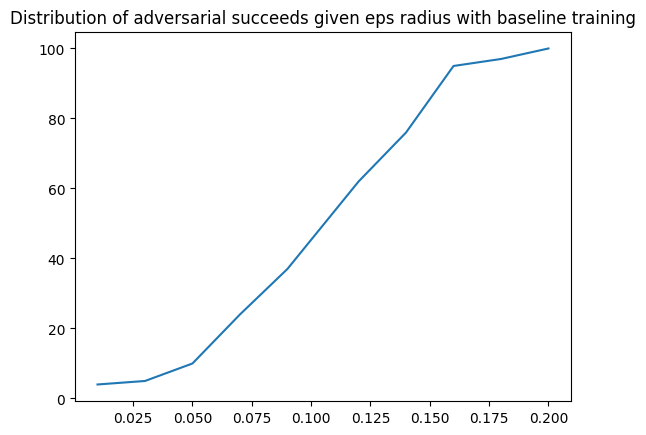

In [49]:
plt.plot(eps_values, adv_acc)
plt.title('Distribution of adversarial succeeds given eps radius with baseline training')

In [50]:
from jacobinet.attacks import get_adv_model

In [51]:
pgd_model = get_adv_model(model, loss= 'logits', epsilon=1e-2, attack='pgd', n_iter=20) # Projected gradient descent attack with 20 iterations


In [52]:
x = layers.Input(shape=(1, 28, 28))
y = layers.Input((10,))

In [53]:
model_adv = keras.models.Model([x, y], [model(x), model(pgd_model([x,y]))]) # concatenate model and its adverarial prediction

In [54]:
model_adv.compile('adam', loss=[keras.losses.CategoricalCrossentropy(from_logits=True), keras.losses.CategoricalCrossentropy(from_logits=True)],
               metrics=['accuracy', 'accuracy'], loss_weights=[1, 1])

In [58]:
model_adv.fit([x_train, y_train], [y_train, y_train], batch_size=128, epochs=2, validation_split=0.1)

Epoch 1/2
422/422 ━━━━━━━━━━━━━━━━━━━━ 231s 546ms/step - loss: 0.3518 - sequential_accuracy: 0.9865 - sequential_accuracy_1: 0.9093 - sequential_loss: 0.3037 - val_loss: 0.2652 - val_sequential_accuracy: 0.9873 - val_sequential_accuracy_1: 0.9338 - val_sequential_loss: 0.2217
Epoch 2/2
422/422 ━━━━━━━━━━━━━━━━━━━━ 229s 543ms/step - loss: 0.2778 - sequential_accuracy: 0.9883 - sequential_accuracy_1: 0.9257 - sequential_loss: 0.2391 - val_loss: 0.2351 - val_sequential_accuracy: 0.9895 - val_sequential_accuracy_1: 0.9402 - val_sequential_loss: 0.1950


In [61]:
model_adv.evaluate([x_test, y_test], [y_test, y_test])

313/313 ━━━━━━━━━━━━━━━━━━━━ 56s 179ms/step - loss: 0.3734 - sequential_3_accuracy: 0.9825 - sequential_3_accuracy_1: 0.9068 - sequential_3_loss: 0.3192


[0.315471351146698,
 0.2704598009586334,
 0.2704598009586334,
 0.9853000044822693,
 0.9215999841690063]

In [59]:
adv_acc_robust

[2.0, 4.0, 4.0, 5.0, 6.0, 6.0, 8.0, 11.0, 22.0, 35.0]

In [62]:
adv_acc_robust

[2.0, 2.0, 2.0, 3.0, 4.0, 6.0, 7.000000000000001, 8.0, 12.0, 17.0]

In [60]:
# test at which radius the model is robust to adversarial attacks
adv_acc_robust=[]

for eps in eps_values:
    print(eps)
    auto_attack = torchattacks.attacks.autoattack.AutoAttack(model, eps=eps)
    adv_data_robust = auto_attack(torch.Tensor(x_test[random_index]), torch.tensor(y_test[random_index].argmax(-1)))
    acc = len(np.where(model.predict(adv_data_robust, verbose=0).argmax(-1)!=y_test[random_index].argmax(-1))[0])/len(random_index)*100
    adv_acc_robust.append(acc)


0.01
0.03
0.05
0.07
0.09
0.12
0.14
0.16
0.18
0.2


Text(0.5, 1.0, 'Distribution of adversarial succeeds given eps radius with baseline and robust training')

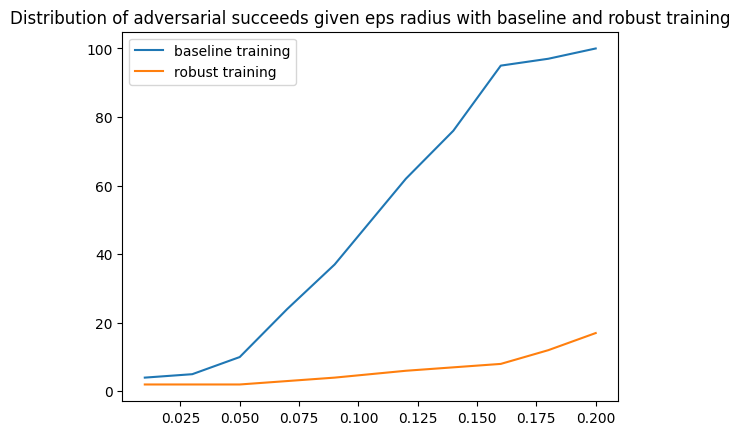

In [61]:
plt.plot(eps_values, adv_acc)
plt.plot(eps_values, adv_acc_robust)
plt.legend(['baseline training', 'robust training'])
plt.title('Distribution of adversarial succeeds given eps radius with baseline and robust training')

In [62]:
#fgsm_attack = torchattacks.FGSM(torch_model, eps=0.1)
#pgd_attack = torchattacks.PGD(torch_model, eps=0.1, steps=1000)
auto_attack = torchattacks.attacks.autoattack.AutoAttack(model, eps=0.2)

#.PGD(torch_lip_model, eps=10., steps=steps)

In [63]:
torch.tensor(y_train[:10].argmax(-1)).dtype

torch.int64

In [64]:
adv_data = auto_attack(torch.Tensor(x_train[:10]), torch.tensor(y_train[:10].argmax(-1)))

In [65]:
model.compile('adam', loss=keras.losses.CategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

In [66]:
model.evaluate(adv_data, y_train[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9000 - loss: 0.2550


[0.2549683153629303, 0.8999999761581421]

In [67]:
adv_data_ = pgd_model([x_train[:10], y_train[:10]])

In [68]:
print(y_train[:10].argmax(-1), model(adv_data_).argmax(-1), model(adv_data).argmax(-1))

[5 0 4 1 9 2 1 3 1 4] tensor([3, 0, 4, 1, 9, 2, 1, 3, 1, 4], device='mps:0') tensor([3, 0, 4, 1, 9, 2, 1, 3, 1, 4], device='mps:0')
